In [1]:
from urban_growth.simulator import *
from urban_growth.estimator import *
from scipy.optimize import approx_fprime
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

# Generate Some Data

In [2]:
# Initial Configuration
L = 300
rho = .47
blur = 3

# model type
model = 'linear_mixture'

# rural-to-urban threshold
T_vec = [100]

# dynamical parameters

pars = {'alpha' : np.array([9, 9]),
        'pi'    : np.array([.3, .7]),
        'gamma' : np.array([3.0, 4.8])
       }

model = 'linear'

Step 1 completed


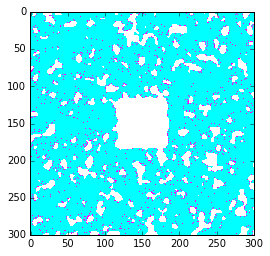

In [3]:
M0 = random_mat(L, rho, blur = blur)
m = simulator(M0 = M0, model = model)

M1 = m.dynamics(T_vec = T_vec,
                n_iters = 1, 
                verbose = True,  
                **pars)

X = M1 - m.M0
X[m.M0 == 1] = np.nan
plt.imshow(X, interpolation = 'nearest', cmap = 'cool')

# First Steps Toward Inference

## Initialize Estimator 

In [4]:
e = estimator(M0 = M0, model = model)
e.update_morphology()
e.partition_clusters(T_vec)
e.make_dist_array(trunc = 50)

In [5]:
e.log_likelihood(X, normalized = True, **pars)

urban_growth/estimator.py:24: RuntimeWarning: divide by zero encountered in log
  ll = np.nansum(X*np.log(d)+(1-X)*np.log(1-d))


-0.14673102667721577

# Gradients

In [6]:
def f(v):
    arr = from_vec(v, model)
    pars = from_array(arr, model)
    return e.log_likelihood(X, normalized = True, **pars)

v = to_vec(to_array(pars, model))
true_grad = from_vec(approx_fprime(v, f, .00000000001), model)
true_grad

array([[ -8.32667268e-06,   5.27355937e-05],
       [  2.80331314e-04,  -3.77475828e-04],
       [ -3.30291350e-04,   6.35602682e-04]])

In [7]:
pars = from_array(from_vec(v, model), model)

ll, computed_grad = e.log_likelihood(X, 
                                     normalized = True, 
                                     use_grad = True, 
                                     **pars)
computed_grad

array([[ -1.11026124e-05,   4.91081429e-05],
       [  2.79983260e-04,  -3.77446787e-04],
       [ -3.33078371e-04,   6.31390408e-04]])

In [8]:
a, b = 10, 10
def g(v):
    arr = from_vec(v, model)
    pars = from_array(arr, model)
    return linear_components(e, 
                             pars['alpha'], 
                             pars['gamma'])[0, a, b]

true_grad = from_vec(approx_fprime(v, g, .00000001), model)
true_grad

array([[ 0.00624622,  0.        ],
       [-0.08872842,  0.        ],
       [ 0.        ,  0.        ]])

In [9]:
c, computed_grad = linear_components(e, 
                             pars['alpha'], 
                             pars['gamma'], use_grad = True)

In [10]:
computed_grad[1, 0, a, b]

-0.08872843192338245

# Maximum Likelihood Estimation (Brute Force)

In [14]:
%%timeit

pars_0 = {'alpha' : np.array([2, 9]),
          'pi'    : np.array([.7, .3]),
          'gamma' : np.array([2.5, 2.8])
       }

pars_hat, ll, h_inv = e.ML(X, 
                           pars_0, 
                           use_grad = True, 
                           opts = {'disp' : True}) 

Optimization terminated successfully.
         Current function value: 0.146721
         Iterations: 34
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.146721
         Iterations: 34
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.146721
         Iterations: 34
         Function evaluations: 41
         Gradient evaluations: 41
Optimization terminated successfully.
         Current function value: 0.146721
         Iterations: 34
         Function evaluations: 41
         Gradient evaluations: 41
1 loop, best of 3: 8.14 s per loop
